# Tutorial del Proyecto K-vecinos más Cercanos

# 1.1 Importamos librerias

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1.2 Importamos el dataframe desde un archivo CSV

In [2]:
# Cargar el dataframe limpio del análisis previo
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/winequality-red.csv', sep=';')

print("✅ Dataframe cargado exitosamente")
print(f"📊 Forma del dataframe: {df.shape}")
df.head()

✅ Dataframe cargado exitosamente
📊 Forma del dataframe: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 1.3 Verificamos valores faltantes

In [3]:
# Verificar valores nulos
print("🔍 Valores faltantes por columna:")
valores_nulos = df.isnull().sum()
porcentaje_nulos = (df.isnull().sum() / len(df)) * 100

resumen_nulos = pd.DataFrame({
    'Columna': df.columns,
    'Valores Nulos': valores_nulos.values,
    '% Nulos': porcentaje_nulos.values
})

# Filtrar solo columnas con valores nulos
resumen_nulos_filtrado = resumen_nulos[resumen_nulos['Valores Nulos'] > 0]

if len(resumen_nulos_filtrado) > 0:
    print(resumen_nulos_filtrado.to_string(index=False))
else:
    print("✅ No hay valores faltantes en el dataset")

🔍 Valores faltantes por columna:
✅ No hay valores faltantes en el dataset


# 1.4 Comprobamos filas y columnas duplicadas

In [4]:
df.duplicated().sum()

np.int64(240)

In [5]:
df.drop_duplicates(inplace=True)
print(f"📊 Nueva forma del dataframe después de eliminar duplicados: {df.shape}")

📊 Nueva forma del dataframe después de eliminar duplicados: (1359, 12)


# 2.1 Split train test

In [6]:
X = df.drop('quality',axis=1)
y = df['quality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.2 Codificamos la variable objetivo

**¿Por qué recodificamos la variable objetivo?**

La variable `quality` originalmente tiene valores que van de 3 a 8 (en una escala de 0-10). Para simplificar el problema de clasificación y mejorar el rendimiento del modelo KNN, agrupamos estos valores en 3 categorías:

- **Calidad Baja (1)**: valores ≤ 4
- **Calidad Media (2)**: valores 5-6  
- **Calidad Alta (3)**: valores ≥ 7

**Beneficios de este enfoque:**
1. **Reduce la complejidad**: Menos clases = modelo más simple y robusto
2. **Balancea mejor las clases**: Evita clases con muy pocas muestras
3. **Mejora la interpretabilidad**: Categorías más claras y prácticas
4. **Aumenta la precisión**: KNN funciona mejor con menos clases bien diferenciadas

**¿Por qué usamos Mapeo Manual?**

- **Mapeo manual**: Es ideal para **agrupar clases ordinales** con significado jerárquico, reduciendo el número de categorías mientras preservamos el orden natural de calidad.

In [8]:
# Verificar los valores únicos actuales
print("📊 Distribución original de 'quality':")
print(y_train.value_counts().sort_index())

# Recodificar la variable objetivo de 1-6 a 1-3
# Asumiendo que quieres agrupar: 1-2 -> 1, 3-4 -> 2, 5-6 -> 3
def recodificar_quality(valor):
    if valor <= 4:
        return 1  # Calidad baja
    elif valor <= 6:
        return 2  # Calidad media
    else:
        return 3  # Calidad alta

y_train_encoded = y_train.map(recodificar_quality)
y_test_encoded = y_test.map(recodificar_quality)

print("\n📊 Distribución recodificada (1-3):")
print(y_train_encoded.value_counts().sort_index())
print(f"\n✅ Variable objetivo recodificada correctamente")

📊 Distribución original de 'quality':
quality
3      6
4     42
5    457
6    432
7    136
8     14
Name: count, dtype: int64

📊 Distribución recodificada (1-3):
quality
1     48
2    889
3    150
Name: count, dtype: int64

✅ Variable objetivo recodificada correctamente


# 2.3 Escalado

In [9]:
# k-NN con datos escalados usando StandardScaler
sc_standard = StandardScaler().fit(X_train)
yhat_standard = KNeighborsClassifier(n_neighbors=3, algorithm='brute').fit(sc_standard.transform(X_train), y_train_encoded).predict(sc_standard.transform(X_test))

📊 ACCURACY SCORE
Accuracy: 0.8088 (80.88%)
Predicciones correctas: 220 de 272

📊 MATRIZ DE CONFUSIÓN
[[  1  14   0]
 [  7 203  13]
 [  0  18  16]]



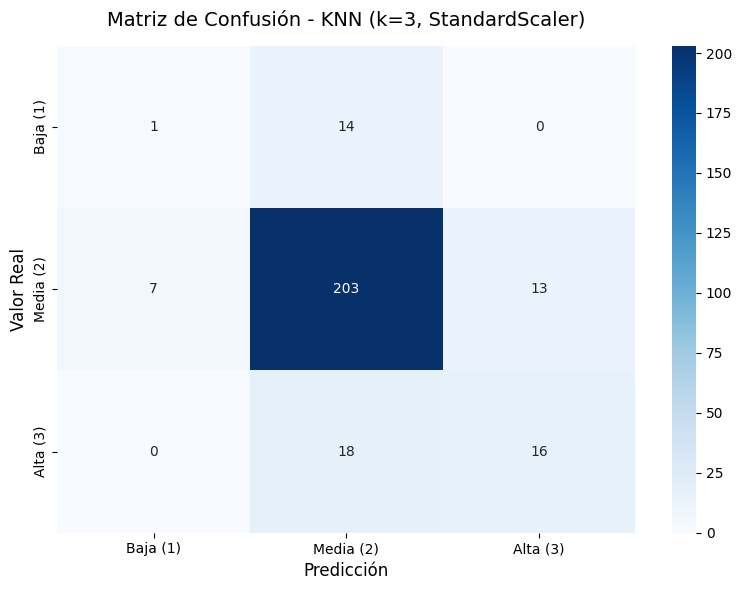


📊 CLASSIFICATION REPORT
               precision    recall  f1-score   support

 Calidad Baja       0.12      0.07      0.09        15
Calidad Media       0.86      0.91      0.89       223
 Calidad Alta       0.55      0.47      0.51        34

     accuracy                           0.81       272
    macro avg       0.51      0.48      0.49       272
 weighted avg       0.78      0.81      0.80       272




In [10]:


# 1. ACCURACY SCORE
accuracy = accuracy_score(y_test_encoded, yhat_standard)
print("=" * 50)
print("📊 ACCURACY SCORE")
print("=" * 50)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Predicciones correctas: {int(accuracy * len(y_test_encoded))} de {len(y_test_encoded)}")
print()

# 2. CONFUSION MATRIX
print("=" * 50)
print("📊 MATRIZ DE CONFUSIÓN")
print("=" * 50)
cm = confusion_matrix(y_test_encoded, yhat_standard)
print(cm)
print()

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baja (1)', 'Media (2)', 'Alta (3)'],
            yticklabels=['Baja (1)', 'Media (2)', 'Alta (3)'])
plt.title('Matriz de Confusión - KNN (k=3, StandardScaler)', fontsize=14, pad=15)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()
print()

# 3. CLASSIFICATION REPORT
print("=" * 50)
print("📊 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test_encoded, yhat_standard, 
                          target_names=['Calidad Baja', 'Calidad Media', 'Calidad Alta']))
print()

# 3.2 Optimización de k

In [12]:
# Probar diferentes valores de k

# Rango de valores de k a probar
k_values = range(1, 21)
accuracy_scores = []
f1_scores = []

# Datos escalados
X_train_scaled = sc_standard.transform(X_train)
X_test_scaled = sc_standard.transform(X_test)

print("🔄 Probando diferentes valores de k...\n")

# Bucle para probar cada valor de k
for k in k_values:
    # Entrenar modelo con k vecinos
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    knn.fit(X_train_scaled, y_train_encoded)
    
    # Predecir
    y_pred = knn.predict(X_test_scaled)
    
    # Calcular métricas
    acc = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='macro')
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    
    print(f"k={k:2d} → Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

print("\n✅ Pruebas completadas")

🔄 Probando diferentes valores de k...

k= 1 → Accuracy: 0.7904 | F1-Score: 0.5328
k= 2 → Accuracy: 0.7868 | F1-Score: 0.4738
k= 3 → Accuracy: 0.8088 | F1-Score: 0.4938
k= 4 → Accuracy: 0.8235 | F1-Score: 0.4662
k= 5 → Accuracy: 0.8199 | F1-Score: 0.4674
k= 6 → Accuracy: 0.8235 | F1-Score: 0.4863
k= 7 → Accuracy: 0.8309 | F1-Score: 0.4831
k= 8 → Accuracy: 0.8346 | F1-Score: 0.4621
k= 9 → Accuracy: 0.8529 | F1-Score: 0.5129
k=10 → Accuracy: 0.8640 | F1-Score: 0.5177
k=11 → Accuracy: 0.8566 | F1-Score: 0.5137
k=12 → Accuracy: 0.8750 | F1-Score: 0.5234
k=13 → Accuracy: 0.8603 | F1-Score: 0.5005
k=14 → Accuracy: 0.8640 | F1-Score: 0.4998
k=15 → Accuracy: 0.8419 | F1-Score: 0.4753
k=16 → Accuracy: 0.8493 | F1-Score: 0.4713
k=17 → Accuracy: 0.8493 | F1-Score: 0.4774
k=18 → Accuracy: 0.8566 | F1-Score: 0.4856
k=19 → Accuracy: 0.8566 | F1-Score: 0.4963
k=20 → Accuracy: 0.8640 | F1-Score: 0.5049

✅ Pruebas completadas


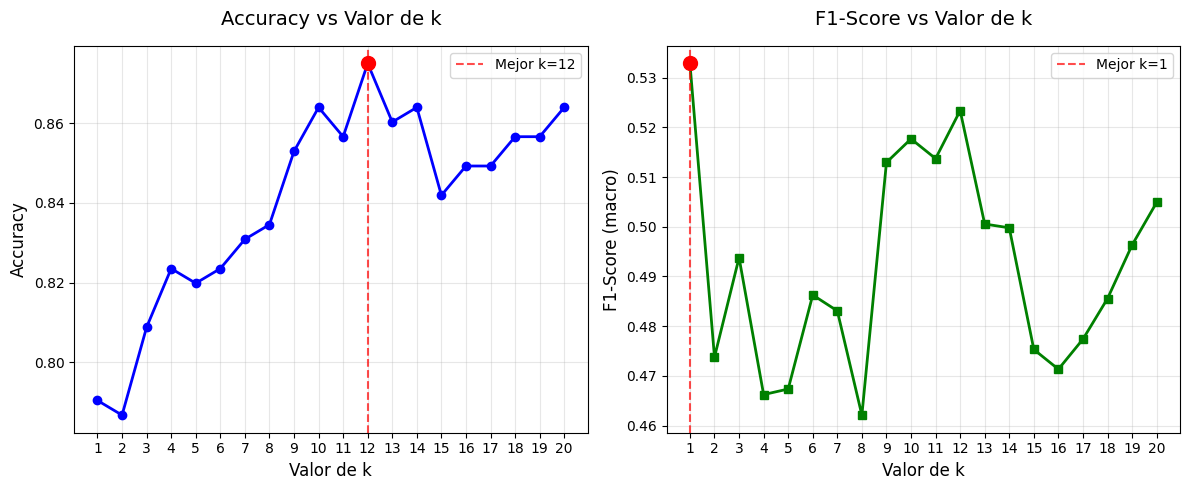

🏆 VALORES ÓPTIMOS DE K
Mejor k según Accuracy: 12 → 0.8750
Mejor k según F1-Score: 1 → 0.5328

💡 Recomendación: Usa el k con mejor F1-Score para clasificación balanceada


In [13]:
# Graficar Accuracy vs k
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', linewidth=2, markersize=6, color='blue')
plt.xlabel('Valor de k', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Valor de k', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Marcar el mejor k para accuracy
best_k_acc = k_values[np.argmax(accuracy_scores)]
best_acc = max(accuracy_scores)
plt.axvline(x=best_k_acc, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k_acc}')
plt.scatter([best_k_acc], [best_acc], color='red', s=100, zorder=5)
plt.legend()

# Subplot 2: F1-Score
plt.subplot(1, 2, 2)
plt.plot(k_values, f1_scores, marker='s', linestyle='-', linewidth=2, markersize=6, color='green')
plt.xlabel('Valor de k', fontsize=12)
plt.ylabel('F1-Score (macro)', fontsize=12)
plt.title('F1-Score vs Valor de k', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Marcar el mejor k para f1-score
best_k_f1 = k_values[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
plt.axvline(x=best_k_f1, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k_f1}')
plt.scatter([best_k_f1], [best_f1], color='red', s=100, zorder=5)
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar resultados óptimos
print("=" * 50)
print("🏆 VALORES ÓPTIMOS DE K")
print("=" * 50)
print(f"Mejor k según Accuracy: {best_k_acc} → {best_acc:.4f}")
print(f"Mejor k según F1-Score: {best_k_f1} → {best_f1:.4f}")
print("\n💡 Recomendación: Usa el k con mejor F1-Score para clasificación balanceada")